<a href="https://colab.research.google.com/github/plaban1981/Deep-Learning-KERAS/blob/master/Age_Category_Classification_using_Tensorflow_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Drive on Colab as the images are stored in the drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Import Necessary Libraries

In [ ]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
#
import warnings
warnings.filterwarnings('ignore')
# 
print(tf.__version__)

2.10.0


## Reproducability

In [ ]:
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

## Data Augmentation

In [ ]:
TRAIN_DIR = "/content/drive/MyDrive/Qualcom/Age_Classification_Data"
datagen = ImageDataGenerator(validation_split=0.2, 
                             rescale=1./255,
                             rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

In [ ]:
train_generator = datagen.flow_from_directory(
    TRAIN_DIR, 
    subset='training',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=8,
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    subset='validation',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=8,
    shuffle=False
)
TEST_DIR = "/content/drive/MyDrive/Qualcom/Test_Data"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    class_mode=None,
    target_size=(224, 224),
    batch_size=1,
    shuffle=False
)

Found 7087 images belonging to 6 classes.
Found 1768 images belonging to 6 classes.
Found 3178 images belonging to 1 classes.


## Some ImageDataGenerator properities

In [ ]:
print(train_generator.class_indices)

{'adult': 0, 'infant': 1, 'kid': 2, 'old': 3, 'teenager': 4, 'young': 5}


In [ ]:
print(val_generator.class_indices)

{'adult': 0, 'infant': 1, 'kid': 2, 'old': 3, 'teenager': 4, 'young': 5}


In [ ]:
print(train_generator.samples)

7087


In [ ]:
print(val_generator.samples)

1768


In [ ]:
type(train_generator)

keras.preprocessing.image.DirectoryIterator

In [ ]:
len(train_generator.labels)

7087

In [ ]:
train_generator.filenames[:5]

['adult/50012eea-1064-4969-b47a-1a28649c46ea.jpg',
 'adult/502cbae6-f70d-43e0-9164-b933e45da1fd.jpg',
 'adult/503fc0a2-fa1f-45a9-907d-26d764f680e3.jpg',
 'adult/5046f101-ed18-4555-832e-9e4f6d9db1fe.jpg',
 'adult/505c8428-64f6-4e31-bca3-6fd771dde664.jpg']

In [ ]:
train_generator.filepaths[:5]

['/content/drive/MyDrive/Qualcom/Age_Classification_Data/adult/50012eea-1064-4969-b47a-1a28649c46ea.jpg',
 '/content/drive/MyDrive/Qualcom/Age_Classification_Data/adult/502cbae6-f70d-43e0-9164-b933e45da1fd.jpg',
 '/content/drive/MyDrive/Qualcom/Age_Classification_Data/adult/503fc0a2-fa1f-45a9-907d-26d764f680e3.jpg',
 '/content/drive/MyDrive/Qualcom/Age_Classification_Data/adult/5046f101-ed18-4555-832e-9e4f6d9db1fe.jpg',
 '/content/drive/MyDrive/Qualcom/Age_Classification_Data/adult/505c8428-64f6-4e31-bca3-6fd771dde664.jpg']

In [ ]:
len(val_generator.labels)

1768

## Retrieve true values from validation dataset

In [ ]:
y_val = val_generator.labels.tolist()

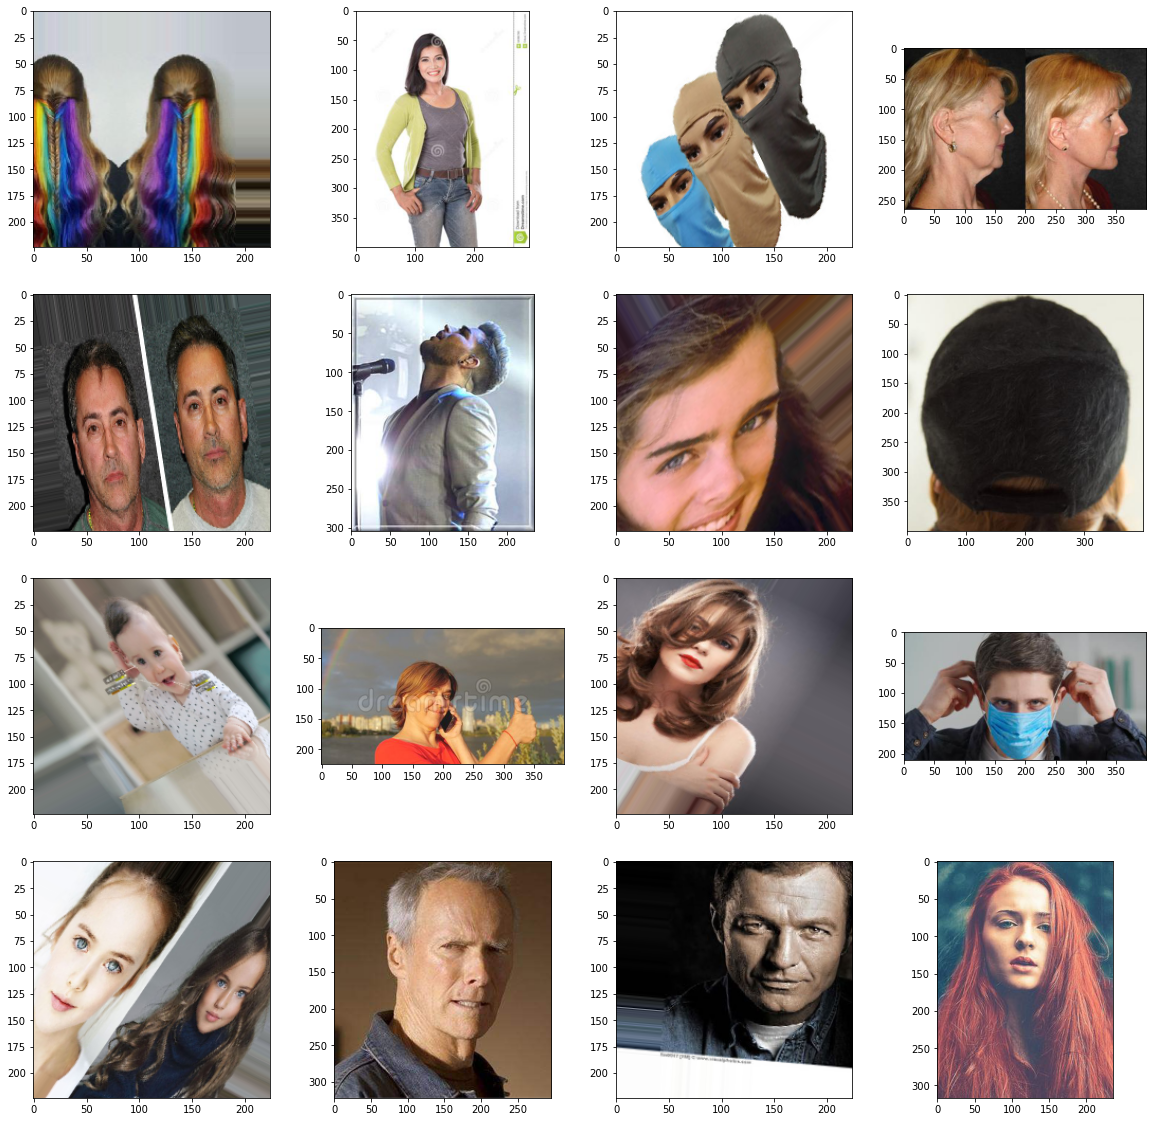

In [ ]:
from skimage import io
for i in range(3):
    x1,y1 = next(train_generator)
    y1_int = np.argmax(y1,axis=-1)
 
#Plot the batch images w.r.t. the dataset images.
plt.figure(figsize=(20,20))
idx=1
for i in range(8):
    plt.subplot(4,4,idx)
    idx+=1
    plt.imshow(x1[i].reshape(224,224,3))
    plt.subplot(4,4,idx)
    plt.imshow(io.imread(os.path.join(train_generator.directory,train_generator.filenames[(train_generator.batch_index-1)*32+i])))
    idx+=1

## Define pretrained Base

In [ ]:
from tensorflow.keras.applications import VGG16,VGG19,NASNetLarge,DenseNet201,ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam

In [ ]:
pretrained_base = DenseNet201(input_shape=(224,224,3), include_top=False, pooling='max',weights='imagenet')

In [ ]:
pretrained_base.trainable = False

## Attach Head

In [ ]:
model = Sequential([
    pretrained_base,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax'),])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 flatten_7 (Flatten)         (None, 1920)              0         
                                                                 
 dense_28 (Dense)            (None, 512)               983552    
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_29 (Dense)            (None, 128)               65664     
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_30 (Dense)            (None, 64)               

## Compile the model

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

## Defiing callbacks

## Arguments

* monitor: quantity to be monitored.
* factor: factor by which the learning rate will be reduced. new_lr = lr * factor.
* patience: number of epochs with no improvement after which learning rate will be reduced.
* verbose: int. 0: quiet, 1: update messages.
* mode: one of {'auto', 'min', 'max'}. In 'min' mode, the learning rate will be reduced when the quantity monitored has stopped decreasing; in 'max' mode it will be reduced when the quantity monitored has stopped increasing; in 'auto' mode, the direction is automatically inferred from the name of the monitored quantity.
* min_delta: threshold for measuring the new optimum, to only focus on significant changes.
* cooldown: number of epochs to wait before resuming normal operation after lr has been reduced.
* min_lr: lower bound on the learning rate.

In [ ]:
folderpath = "/content/drive/MyDrive/Qualcom/Model"
filepath = folderpath + "DenseNet201/epoch:{epoch:02d}-val_loss:{val_loss:.2f}.hdf5"

* https://keras.io/api/callbacks/model_checkpoint/
* https://keras.io/api/callbacks/reduce_lr_on_plateau/
* https://keras.io/api/callbacks/early_stopping/

In [ ]:
cbs = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1,mode='auto', min_lr=1e-5, verbose=1),
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5, verbose=1, mode='auto'),
      tf.keras.callbacks.ModelCheckpoint(filepath=filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True),
       too_many_models(mypath=folderpath, max_num_of_models=5)]

## Train the Model

In [ ]:
batch_size = 8
history = model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=100,
        validation_data=val_generator,
        validation_steps=800 // batch_size,
        callbacks=[cbs])

Epoch 1/100
250/250 [==============================] - 83s 292ms/step - loss: 2.2166 - accuracy: 0.2140 - val_loss: 1.7182 - val_accuracy: 0.6075 - lr: 0.0010
Epoch 2/100
250/250 [==============================] - 68s 274ms/step - loss: 1.7438 - accuracy: 0.2651 - val_loss: 1.5638 - val_accuracy: 0.6587 - lr: 0.0010
Epoch 3/100
250/250 [==============================] - 67s 267ms/step - loss: 1.6865 - accuracy: 0.2985 - val_loss: 1.5139 - val_accuracy: 0.3050 - lr: 0.0010
Epoch 4/100
250/250 [==============================] - 68s 271ms/step - loss: 1.6766 - accuracy: 0.3005 - val_loss: 1.4435 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 5/100
250/250 [==============================] - ETA: 0s - loss: 1.6202 - accuracy: 0.3390
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
250/250 [==============================] - 68s 271ms/step - loss: 1.6202 - accuracy: 0.3390 - val_loss: 1.4883 - val_accuracy: 0.5337 - lr: 0.0010
Epoch 6/100
250/250 [=======================

## Examine the loss and accuracy

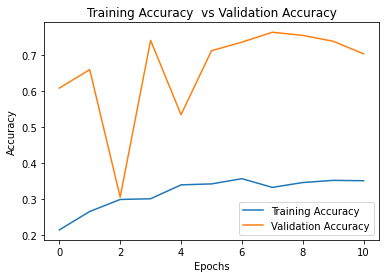

In [ ]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()
plt.title('Training Accuracy  vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

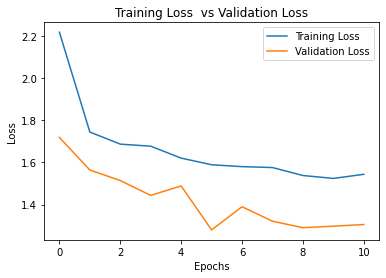

In [ ]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()
plt.title('Training Loss  vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Evaluate the Model by loading the best model

In [ ]:
chekpoint_filepath = "/content/drive/MyDrive/Qualcom/ModelDenseNet201/epoch:06-val_loss:1.28.hdf5"
model.load_weights(chekpoint_filepath)

In [ ]:
preds = model.predict(val_generator)

221/221 [==============================] - 38s 160ms/step


In [ ]:
predictions = np.argmax(preds,axis=1)

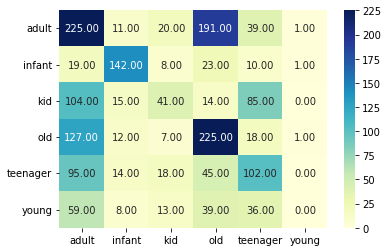

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_val,predictions),
            xticklabels=['adult', 'infant', 'kid', 'old', 'teenager', 'young'],
            yticklabels=['adult', 'infant', 'kid', 'old', 'teenager', 'young'],
            cmap="YlGnBu",
            annot=True,
            fmt=".2f")
plt.show()

## Save the model

In [ ]:
model.save('Densenet201_model.hdf5')

In [ ]:
import shutil
shutil.move("/content/Densenet201_model.hdf5","/content/drive/MyDrive/Qualcom/ModelDenseNet201")

'/content/drive/MyDrive/Qualcom/ModelDenseNet201/Densenet201_model.hdf5'

## Load the saved Model

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('/content/drive/MyDrive/Qualcom/ModelDenseNet201/Densenet201_model.hdf5')

## Make inference on the test data

In [ ]:
test_data_predictions  = loaded_model.predict(test_generator)

3178/3178 [==============================] - 801s 251ms/step


In [ ]:
test_predictions = np.argmax(test_data_predictions,axis=1)

In [ ]:
file_names = test_generator.filenames

## Prepare Submission File

In [ ]:
import pandas as pd
df_submission = pd.DataFrame({"filename":file_names,"predictions":test_predictions})

In [ ]:
df_submission.head()

filename  predictions
0  Test/000a7aa8-2726-4af0-a065-a86a316160ec.jpg            1
1  Test/000f5014-6360-42be-9a68-420381d783ca.jpg            3
2  Test/0025e426-98de-46c0-b640-e7e28b06f5bd.jpg            4
3  Test/002adda1-9f83-485d-9242-0e3df2805569.jpg            3
4  Test/004e6a5c-6632-4e7e-b4a9-9efdc5b31ed1.jpg            0

In [ ]:
train_generator.class_indices

{'adult': 0, 'infant': 1, 'kid': 2, 'old': 3, 'teenager': 4, 'young': 5}

In [ ]:
label_dict = {v:k for k,v in train_generator.class_indices.items()}
label_dict

{0: 'adult', 1: 'infant', 2: 'kid', 3: 'old', 4: 'teenager', 5: 'young'}

In [ ]:
df_submission['predictions'] = df_submission['predictions'].map(label_dict)

In [ ]:
df_submission.head()

filename predictions
0  Test/000a7aa8-2726-4af0-a065-a86a316160ec.jpg      infant
1  Test/000f5014-6360-42be-9a68-420381d783ca.jpg         old
2  Test/0025e426-98de-46c0-b640-e7e28b06f5bd.jpg    teenager
3  Test/002adda1-9f83-485d-9242-0e3df2805569.jpg         old
4  Test/004e6a5c-6632-4e7e-b4a9-9efdc5b31ed1.jpg       adult